# Post process for coloc results
Author: Ru Feng and Jenny Empawi

### Load libraries

In [1]:
library(data.table)
library(tidyverse)
library(clusterProfiler)  # for enrichment
library(org.Hs.eg.db)     # for human gene annotation
library(enrichplot)       # for plotting
library(DOSE)             # for visualization support
library(ggplot2)
library(dplyr)
library(tidyr)
library(forcats)
library(ggnewscale)  # <--- for multiple fill scales

── Attaching core tidyverse packages ──────────────────────── tidyverse 2.0.0 ──
✔ dplyr     1.1.4     ✔ readr     2.1.5
✔ forcats   1.0.1     ✔ stringr   1.6.0
✔ ggplot2   4.0.0     ✔ tibble    3.3.0
✔ lubridate 1.9.4     ✔ tidyr     1.3.1
✔ purrr     1.2.0     
── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::between()     masks data.table::between()
✖ dplyr::filter()      masks stats::filter()
✖ dplyr::first()       masks data.table::first()
✖ lubridate::hour()    masks data.table::hour()
✖ lubridate::isoweek() masks data.table::isoweek()
✖ dplyr::lag()         masks stats::lag()
✖ dplyr::last()        masks data.table::last()
✖ lubridate::mday()    masks data.table::mday()
✖ lubridate::minute()  masks data.table::minute()
✖ lubridate::month()   masks data.table::month()
✖ lubridate::quarter() masks data.table::quarter()
✖ lubridate::second()  masks data.table::second()
✖ purrr::transpose()   masks data.table::transpose()
✖ lubridate::wday() 

In [2]:
#source("/restricted/projectnb/xqtl/jaempawi/xqtl/Figure_2d/merge_coloc_also_within_loci.R") # path in BU cluster
#setwd("/restricted/projectnb/xqtl/jaempawi/xqtl/Figure_2d") 

source("/data/interactive_analysis/rf2872/FunGen_xQTL/2025/May/merge_coloc_also_within_loci.R") # path in cloud
setwd("/data/interactive_analysis/rf2872/FunGen_xQTL/2025/May") # path in cloud

### Load data

In [3]:
#coloc_dirs <- list.files('/data/analysis_result/coloc', recursive = F, full.names = T)
#coloc_dirs <- coloc_dirs %>% .[str_detect(., 'metabolites')]
#coloc_dirs

In [4]:
#coloc_res_paths <- c()
#for(coloc_dir in coloc_dirs){
#    coloc_res_paths <- c(coloc_res_paths, list.files(coloc_dir, 'coloc_res', recursive = T, full.names = T))
#}


In [5]:
#coloc_res_paths_df <- data.frame(file_path = coloc_res_paths %>% gsub('coloc_res', 'rds',. ), 
#                                 base_id = basename(coloc_res_paths)) %>% 
#                                    mutate(metabolite_region = str_split(base_id, '[.]', simplify = T) %>% .[,1],
#                                           context_region = str_split(base_id, '[.]', simplify = T) %>% .[,2])
#coloc_res_paths_df %>% head

In [6]:
#coloc_res_paths_df %>% pull(file_path) %>% length 

In [7]:
#res <- list()

#metabolite_ids <- unique(coloc_res_paths_df$metabolite_region)

#for (i in seq_along(metabolite_ids)) {
#  tryCatch({
#    metabolite_id <- metabolite_ids[i]
    
#    same_region_path <- coloc_res_paths_df %>%
#      filter(metabolite_region == metabolite_id) %>%
#      pull(file_path)
    
#    res[[i]] <- merge_coloc_sets(same_region_path, overlap_pip_sum_threshold = 0.5)
    
#    if (i %% 20 == 0) {
#      message(sprintf("Completed %d out of %d jobs", i, length(metabolite_ids)))
#    }
#  }, error = function(e) {
#    message(sprintf("Error in %s: %s", metabolite_ids[i], e$message))
#  })
#}

In [8]:
# start here ~
res <- readRDS('FunGen_xQTL_metabolites.coloc70.merged.Apr2025.rds')

In [9]:
# Extract and convert each CoS_union_outcomes to character
res_char <- lapply(res, function(x) {
  x$merged_cos$CoS_union_outcomes %>% unlist %>% as.character()
})

res_df <- data.frame(merged_pair = unlist(res_char) %>% as.character()) %>%
  mutate(
    split_parts = str_split(merged_pair, "; "),
    metabolite_region = map_chr(split_parts, ~ .x[1]) %>% gsub('ROSMAP_metaQTL.', '', .) %>% gsub('.univariate_susie_twas_weights', '', .),
    contexts = map(split_parts, ~ .x[-1])
  ) %>%
  dplyr::select(-split_parts, -merged_pair)

res_df_sum <- res_df %>%
  mutate(metabolite = str_extract(metabolite_region, "ROSMAP.+$")) %>%
  group_by(metabolite) %>%
  summarise(
    metabolite_regions = paste(metabolite_region %>% unique, collapse = "; "),
    contexts = contexts %>% flatten_chr() %>% unique %>% paste(collapse = "; ")
  )

res_df_sum <- res_df_sum %>%
  mutate(
    # Split context by ";", then extract ENSG IDs from each part using regex
    ensg_ids = str_extract_all(contexts, "ENSG\\d+")
  ) %>%
  rowwise() %>%
  mutate(
    # Count number of unique ENSG IDs
    n_gene = length(unique(ensg_ids))
  ) %>%
  ungroup() %>%
  dplyr::select(metabolite, n_gene) %>% left_join(res_df_sum)

res_df_sum %>% pull(n_gene) %>% summary

Joining with `by = join_by(metabolite)`


   Min. 1st Qu.  Median    Mean 3rd Qu.    Max. 
  0.000   1.000   1.000   2.158   3.000  30.000 

In [10]:
res_df_sum %>% pull(metabolite) %>% unique %>% length

[1] 259

In [11]:
res_df_sum %>% arrange(desc(n_gene)) %>% head

metabolite                      n_gene
1 ROSMAP_metabolome_CHEM100000282 30    
2 ROSMAP_metabolome_CHEM100001851 18    
3 ROSMAP_metabolome_CHEM100001662 15    
4 ROSMAP_metabolome_CHEM100015624 10    
5 ROSMAP_metabolome_CHEM189       10    
6 ROSMAP_metabolome_CHEM331       10    
  metabolite_regions                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                   
1 chr11_116513409_117835187_ROSMAP_metabolome_CHEM100000282; chr18_68166377_69581483_ROSMAP_metabolome_CHEM100000282; chr8_6537503_8880095_ROSMAP_metabolome_CHEM100000282; chr10_82231647_83966001_ROSMAP_metabolome_CHEM100000282; chr12_2067099_3219245_ROSMAP_metabolome_CHEM100000282; chr18_7090236_8658509_ROSMAP_metabolome_CHEM100000282; chr1_234364329_235656952_ROSMAP_metabolome_CHEM100000282; chr1_81525772_83003483_ROSMAP_metabolome_CHEM100000282; chr22_10516173_17414263_ROSMAP_metabolome_CHEM100000282; chr2_131938574_134400811_ROSMAP_metabolome_CHEM100000282; chr2_3926189_5567778_ROSMAP_metabolome_CHEM100000282; chr3_112690384_114706122_ROSMAP_metabolome_CHEM100000282; chr3_42375669_45108216_ROSMAP_metabolome_CHEM100000282; chr4_126353190_128547006_ROSMAP_metabolome_CHEM100000282; chr4_43205452_47542521_ROSMAP_metabolome_CHEM100000282; chr7_128149110_129951388_ROSMAP_metabolome_CHEM100000282; chr8_143034200_145075767_ROSMAP_metabolome_CHEM100000282; chr8_97568971_100485780_ROSMAP_metabolome_CHEM100000282; chr4_182023425_183841077_ROSMAP_metabolome_CHEM100000282
2 chr18_68166377_69581483_ROSMAP_metabolome_CHEM100001851; chr8_74340073_76961768_ROSMAP_metabolome_CHEM100001851; chr10_1693015_2596251_ROSMAP_metabolome_CHEM100001851; chr11_116513409_117835187_ROSMAP_metabolome_CHEM100001851; chr12_102729561_104526113_ROSMAP_metabolome_CHEM100001851; chr12_2067099_3219245_ROSMAP_metabolome_CHEM100001851; chr18_7090236_8658509_ROSMAP_metabolome_CHEM100001851; chr18_71953820_73750620_ROSMAP_metabolome_CHEM100001851; chr1_234364329_235656952_ROSMAP_metabolome_CHEM100001851; chr1_81525772_83003483_ROSMAP_metabolome_CHEM100001851; chr2_3926189_5567778_ROSMAP_metabolome_CHEM100001851; chr7_128149110_129951388_ROSMAP_metabolome_CHEM100001851; chr8_71102974_72924454_ROSMAP_metabolome_CHEM100001851; chr8_71179_1212769_ROSMAP_metabolome_CHEM100001851; chr8_97568971_100485780_ROSMAP_metabolome_CHEM100001851; chr9_99996542_101945775_ROSMAP_metabolome_CHEM100001851                                                                                                                                                                                  
3 chr1_195599253_199271134_ROSMAP_metabolome_CHEM100001662; chr7_12595836_13740859_ROSMAP_metabolome_CHEM100001662; chr2_130787741_131938574_ROSMAP_metabolome_CHEM100001662; chr10_1693015_2596251_ROSMAP_metabolome_CHEM100001662; chr18_31787670_34878947_ROSMAP_metabolome_CHEM100001662; chr21_44518132_46696121_ROSMAP_metabolome_CHEM100001662; chr2_179338809_182822595_ROSMAP_metabolome_CHEM100001662; chr4_125559113_126353190_ROSMAP_metabolome_CHEM100001662; chr5_121650726_1

In [12]:
res_df_sum %>%
  mutate(genes = str_extract_all(contexts, "ENSG\\d+")) %>%
  unnest(genes) %>%
  distinct() %>% dim

[1] 559   5

In [13]:
metabolite_genes <- res_df_sum %>% pull(contexts) %>% str_extract_all(., "ENSG\\d+") %>% unlist%>% unique
metabolite_genes %>% length

[1] 381

In [14]:
#metabolite_genes %>% writeLines('FunGen_xQTL_metabolites_coloc_genes.txt')

### KEGG analysis

'select()' returned 1:many mapping between keys and columns

Warning message in bitr(metabolite_genes, fromType = "ENSEMBL", toType = "ENTREZID", :
“2.1% of input gene IDs are fail to map...”
Reading KEGG annotation online: "https://rest.kegg.jp/link/hsa/pathway"...

Reading KEGG annotation online: "https://rest.kegg.jp/list/pathway/hsa"...

Warning message in fortify(object, showCategory = showCategory, by = x, ...):
“Arguments in `...` must be used.
✖ Problematic argument:
• by = x
ℹ Did you misspell an argument name?”
Warning message:
“`aes_string()` was deprecated in ggplot2 3.0.0.
ℹ Please use tidy evaluation idioms with `aes()`.
ℹ See also `vignette("ggplot2-in-packages")` for more information.
ℹ The deprecated feature was likely used in the enrichplot package.
  Please report the issue at
  <https://github.com/GuangchuangYu/enrichplot/issues>.”


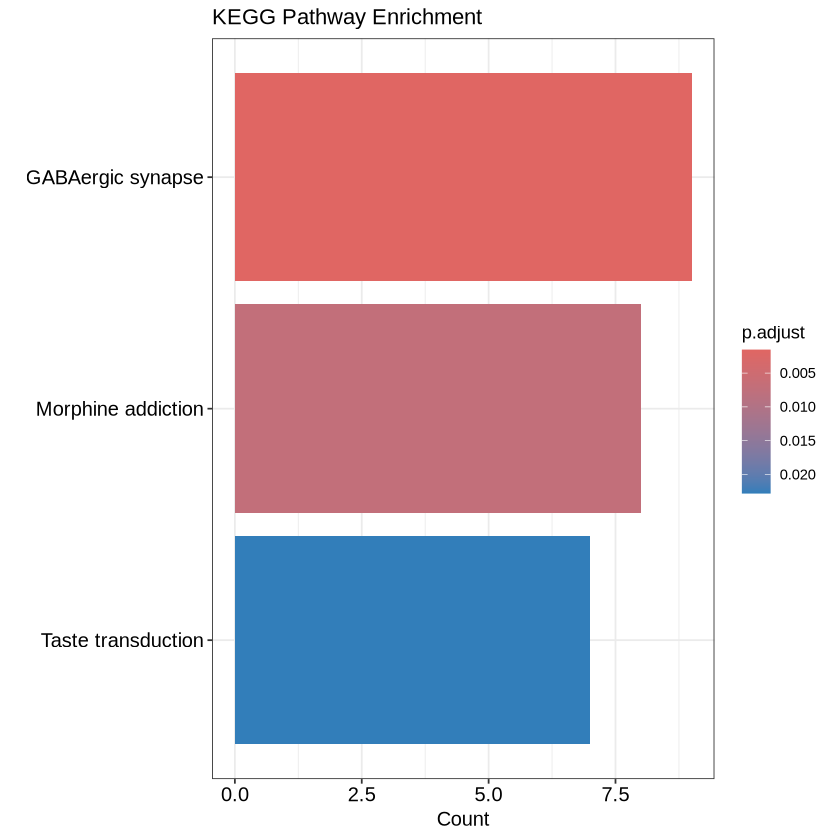

In [15]:
# Convert gene symbols to Entrez IDs
entrez_ids <- bitr(metabolite_genes, fromType = "ENSEMBL", 
                   toType = "ENTREZID", OrgDb = org.Hs.eg.db)

# Run KEGG enrichment
kegg_enrich <- enrichKEGG(gene         = entrez_ids$ENTREZID,
                          organism     = 'hsa',
                          pvalueCutoff = 0.05)

# Visualize results
p1 <- barplot(kegg_enrich, showCategory = 20, title = "KEGG Pathway Enrichment")
p1

In [16]:
kegg_enrich@result %>% head

,category,subcategory,ID,Description,GeneRatio,BgRatio,RichFactor,FoldEnrichment,zScore,pvalue,p.adjust,qvalue,geneID,Count
,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<chr>,<int>
hsa04727,Organismal Systems,Nervous system,hsa04727,GABAergic synapse,9/141,89/9497,0.10112360,6.811140,6.761492,6.299276e-06,0.001555921,0.001485303,2555/6539/9568/775/2557/2566/2561/5567/114,9
hsa05032,Human Diseases,Substance dependence,hsa05032,Morphine addiction,8/141,91/9497,0.08791209,5.921284,5.790705,5.825565e-05,0.007194572,0.006868034,2555/9568/2557/2566/2561/5136/5567/114,8
hsa04742,Organismal Systems,Sensory system,hsa04742,Taste transduction,7/141,86/9497,0.08139535,5.482352,5.125923,2.769340e-04,0.022800900,0.021766042,2555/9568/775/2557/5136/5567/114,7
hsa04082,NA,NA,hsa04082,Neuroactive ligand signaling,9/141,199/9497,0.04522613,3.046188,3.581065,2.811268e-03,0.152118612,0.145214443,2555/6539/9568/2898/2557/2566/2561/5567/114,9
hsa05033,Human Diseases,Substance dependence,hsa05033,Nicotine addiction,4/141,41/9497,0.09756098,6.571181,4.388542,3.079324e-03,0.152118612,0.145214443,2555/2557/2566/2561,4
hsa05414,Human Diseases,Cardiovascular disease,hsa05414,Dilated cardiomyopathy,6/141,105/9497,0.05714286,3.848835,3.603443,4.653883e-03,0.191584870,0.182889456,775/8516/93589/137868/5567/114,6


### Heatmap

In [17]:
res_df_sum <- fread('FunGen_xQTL_metabolites.coloc70.merged.Apr2025.flatten.tsv')
metabolite_meta <- fread('ROSMAP Metabolon HD4 Data Dictionary.csv')
metabolite_meta <- metabolite_meta %>% mutate(metabolite = paste0('CHEM', CHEM_ID))
metabolite_meta %>% head

CHEM_ID,LIB_ID,COMP_ID,CHRO_LIB_ENTRY_ID,SUPER_PATHWAY,SUB_PATHWAY,PATHWAY_SORTORDER,PATHWAY_STATUS,TYPE,INCHIKEY,⋯,CHEMICAL_NAME,SHORT_NAME,CAS,CHEMSPIDER,HMDB,KEGG,PLANT_CYC,PUBCHEM,PLATFORM,metabolite
<int>,<int>,<int>,<int>,<chr>,<chr>,<int>,<lgl>,<chr>,<chr>,⋯,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>
35,400,42370,166164,Amino Acid,Glutamate Metabolism,62,NA,NAMED,DWAKNKKXGALPNW-REWHXWOFAV,⋯,S-1-pyrroline-5-carboxylate,S-1-pyrroline-5-carboxylate,2906-39-0,10140206,HMDB0001301,C04322,,11966181,LC/MS Pos Early,CHEM35
41,400,1633,155434,Amino Acid,Histidine Metabolism,85,NA,NAMED,CCLQKVKJOGVQLU-QMMMGPOBBT,⋯,homocarnosine,homocarnosine,3650-73-5,8418848,HMDB0000745,C00884,,"89235,10243361",LC/MS Pos Early,CHEM41
49,400,1408,155357,Amino Acid,Polyamine Metabolism,537,NA,NAMED,KIDHWZJUCRJVML-UHFFFAOYAX,⋯,putrescine,putrescine,110-60-1,13837702,HMDB0001414,C00134,PUTRESCINE,1045,LC/MS Pos Early,CHEM49
50,400,485,155305,Amino Acid,Polyamine Metabolism,545,NA,NAMED,ATHGHQPFGPMSJY-UHFFFAOYAK,⋯,spermidine,spermidine,124-20-9,1071,HMDB0001257,C00315,SPERMIDINE,1102,LC/MS Pos Early,CHEM50
55,400,27665,155829,Cofactors and Vitamins,Nicotinate and Nicotinamide Metabolism,4314,NA,NAMED,LDHMAVIPBRSVRG-UHFFFAOYAE,⋯,1-methylnicotinamide,1-methylnicotinamide,1005-24-9,8305504,HMDB0000699,C02918,,457,LC/MS Pos Early,CHEM55
62,209,38395,143675,Lipid,"Fatty Acid, Dihydroxy",2030,NA,NAMED,CQSLTKIXAJTQGA-FLIBITNWBI,⋯,"12,13-DiHOME","12,13-DiHOME",263399-35-5,8412123,HMDB0004705,C14829,CPD-13086,10236635,LC/MS Neg,CHEM62


In [18]:
metabolite_meta %>% pull(SHORT_NAME) %>% unique 

[1] "S-1-pyrroline-5-carboxylate"                                        
   [2] "homocarnosine"                                                      
   [3] "putrescine"                                                         
   [4] "spermidine"                                                         
   [5] "1-methylnicotinamide"                                               
   [6] "12,13-DiHOME"                                                       
   [7] "cytidine 2',3'-cyclic monophosphate"                                
   [8] "alpha-ketoglutarate"                                                
   [9] "kynurenate"                                                         
  [10] "3-hydroxyisobutyrate"                                               
  [11] "3-hydroxy-3-methylglutarate"                                        
  [12] "homovanillate (HVA)"                                                
  [13] "3-phosphoglycerate"                                                 
  [14] "cholate"                                                            
  [15] "gamma-aminobutyrate (GABA)"                                         
  [16] "4-hydroxyphenylacetate"                                             
  [17] "5,6-dihydrothymine"                                                 
  [18] "hypoxanthine"                                                       
  [19] "guanine"                                                            
  [20] "9,10-DiHOME"                                                        
  [21] "linoleate (18:2n6)"                                                 
  [22] "N6,N6,N6-trimethyllysine"                                           
  [23] "N-acetylputrescine"                                                 
  [24] "N-formylmethionine"                                                 
  [25] "S-adenosylhomocysteine (SAH)"                                       
  [26] "ADP"                                                                
  [27] "AMP"                                                                
  [28] "5-methylthioadenosine (MTA)"                                        
  [29] "N6-methyladenosine"                                                 
  [30] "adenosine 5'-diphosphoribose (ADP-ribose)"                          
  [31] "arachidonate (20:4n6)"                                              
  [32] "arginine"                                                           
  [33] "argininosuccinate"                                                  
  [34] "ascorbate (Vitamin C)"                                              
  [35] "aspartate"                                                          
  [36] "3-(4-hydroxyphenyl)lactate (HPLA)"                                  
  [37] "carnosine"                                                          
  [38] "biliverdin"                                                         
  [39] "3-hydroxybutyrate (BHBA)"                                           
  [40] "7-dehydrocholesterol"                                               
  [41] "cholesterol"                                                        
  [42] "phosphocholine"                                                     
  [43] "CoA-glutathione*"                                                   
  [44] "CoA"                                                                
  [45] "corticosterone"                                                     
  [46] "cortisone"                                                          
  [47] "creatinine"                                                         
  [48] "cysteinylglycine"                                                   
  [49] "cystine"                                                            
  [50] "glucosamine-6-phosphate"                                            
  [51] "glucose 6-phosphate"                                                
  [52] "mannose 6-phosphate"                                                

In [19]:
metabolite_meta %>% pull(SUB_PATHWAY) %>% unique 

[1] "Glutamate Metabolism"                                        
  [2] "Histidine Metabolism"                                        
  [3] "Polyamine Metabolism"                                        
  [4] "Nicotinate and Nicotinamide Metabolism"                      
  [5] "Fatty Acid, Dihydroxy"                                       
  [6] "Pyrimidine Metabolism, Cytidine containing"                  
  [7] "TCA Cycle"                                                   
  [8] "Tryptophan Metabolism"                                       
  [9] "Leucine, Isoleucine and Valine Metabolism"                   
 [10] "Mevalonate Metabolism"                                       
 [11] "Tyrosine Metabolism"                                         
 [12] "Glycolysis, Gluconeogenesis, and Pyruvate Metabolism"        
 [13] "Primary Bile Acid Metabolism"                                
 [14] "Phenylalanine Metabolism"                                    
 [15] "Pyrimidine Metabolism, Thymine containing"                   
 [16] "Purine Metabolism, (Hypo)Xanthine/Inosine containing"        
 [17] "Purine Metabolism, Guanine containing"                       
 [18] "Long Chain Polyunsaturated Fatty Acid (n3 and n6)"           
 [19] "Lysine Metabolism"                                           
 [20] "Methionine, Cysteine, SAM and Taurine Metabolism"            
 [21] "Purine Metabolism, Adenine containing"                       
 [22] "Urea cycle; Arginine and Proline Metabolism"                 
 [23] "Ascorbate and Aldarate Metabolism"                           
 [24] "Alanine and Aspartate Metabolism"                            
 [25] "Hemoglobin and Porphyrin Metabolism"                         
 [26] "Ketone Bodies"                                               
 [27] "Sterol"                                                      
 [28] "Phospholipid Metabolism"                                     
 [29] "Glutathione Metabolism"                                      
 [30] "Pantothenate and CoA Metabolism"                             
 [31] "Corticosteroids"                                             
 [32] "Creatine Metabolism"                                         
 [33] "Aminosugar Metabolism"                                       
 [34] "Fructose, Mannose and Galactose Metabolism"                  
 [35] "Sphingosines"                                                
 [36] "Secondary Bile Acid Metabolism"                              
 [37] "Sphingolipid Synthesis"                                      
 [38] "Riboflavin Metabolism"                                       
 [39] "Gamma-glutamyl Amino Acid"                                   
 [40] "Nucleotide Sugar"                                            
 [41] "Food Component/Plant"                                        
 [42] "Fatty Acid, Dicarboxylate"                                   
 [43] "Glycine, Serine and Threonine Metabolism"                    
 [44] "Inositol Metabolism"                                         
 [45] "Fatty Acid Metabolism (also BCAA Metabolism)"                
 [46] "Long Chain Saturated Fatty Acid"                             
 [47] "Medium Chain Fatty Acid"                                     
 [48] "Pyrimidine Metabolism, Orotate containing"                   
 [49] "Long Chain Monounsaturated Fatty Acid"                       
 [50] "Oxidative Phosphorylation"                                   
 [51] "Eicosanoid"                                                  
 [52] "Vitamin B6 Metabolism"                                       
 [53] "Vitamin A Metabolism"                                        
 [54] "Drug - Topical Agents"                                       
 [55] "Pyrimidine Metabolism, Uracil containing"                    
 [56] "Fatty Acid Synthesis"                                        
 [57] "Pentose Metabolism"                                          
 [58] "Tobacco Metabolite"                                          


In [20]:
metabolite_meta %>% dim

[1] 1055   21

In [21]:
expand_context_entries <- function(x) {
  # First split by "; " to separate main entries
    split_main <- str_split(x, "; ")[[1]]
  
  # Initialize result
  expanded <- c()
  
  for (entry in split_main) {
    # Check if there is a pattern like ..._bvsr_...;...
    if (str_detect(entry, "_bvsr_") && str_count(entry, ";") > 0) {
      # Get the prefix before the first semicolon
      prefix <- str_split(entry, "_bvsr_", simplify = TRUE)[,1]
      suffixes <- str_split(entry, "_bvsr_", simplify = TRUE)[,2] %>%
        str_split(";", simplify = FALSE) %>% unlist()
      expanded <- c(expanded, paste0(prefix, "_bvsr_", suffixes))
    } else {
      expanded <- c(expanded, entry)
    }
  }
  
  paste(expanded, collapse = "; ")
}


res_df_sum_long <- res_df_sum %>%
  rowwise() %>%
  mutate(contexts = expand_context_entries(contexts)) %>% 
  separate_rows(contexts, sep = ";\\s*") %>%
  mutate(
    # Extract and clean context identifiers
    context_clean = str_extract(contexts, "_(ROSMAP|KNIGHT|MSBB|Metabrain|STARNET|Exc|Inh|Ast|Mic|OPC|Oli|Knight|KnightADRC|MiGA|AC|PCC|DLPFC)_[^\\.]+|^(AC|PCC|DLPFC|Exc|Inh|Ast|Mic|OPC|Oli)_[^\\.]+") %>%
      str_remove("_chr.+$") %>%
      str_remove("_ENSG[0-9]+") %>%
      str_remove("_gp.+$") %>%
      str_remove("^_"),
    
    # Adjust specific context names
    context_clean = ifelse(context_clean == 'DLPFC_Klein', 'DLPFC_Klein_pQTL', context_clean),
    context_clean = ifelse(str_detect(context_clean, 'Metabrain'), paste0(context_clean, '_eQTL'), context_clean),
    context_clean = ifelse(str_detect(contexts, 'monocyte_ROSMAP_eQTL'), 'ROSMAP_monocyte_eQTL', context_clean),
    context_clean = ifelse(str_detect(contexts, 'multicontext'), str_replace(context_clean, 'QTL', 'QTL_multi'), context_clean),
    context_clean = ifelse(str_detect(context_clean, 'Exc|Inh|Ast|Mic|OPC|Oli') & !str_detect(context_clean, 'multi'), 
                           str_replace(context_clean, '_eQTL', '_snuc_eQTL'), context_clean),
    
    # Clean metabolite name
    metabolite = str_replace(metabolite, "ROSMAP_metabolome_", "")
    #   ,
    
    # # Count number of ENSG gene IDs per context
    # n_gene = str_count(contexts, "ENSG\\d+")
  ) 

res_df_sum_long %>% filter(metabolite == 'CHEM100000272')

metabolite,n_gene,metabolite_regions,contexts,context_clean
<chr>,<int>,<chr>,<chr>,<chr>
CHEM100000272,1,chr7_128149110_129951388_ROSMAP_metabolome_CHEM100000272,RSS_QC_RAISS_imputed.chr7_127476747_130880000_ENSG00000165055.univariate_susie_rss_Metabrain_Cerebellum,Metabrain_Cerebellum_eQTL
CHEM100000272,1,chr7_128149110_129951388_ROSMAP_metabolome_CHEM100000272,RSS_QC_RAISS_imputed.chr7_127476747_130880000_ENSG00000165055.univariate_susie_rss_Metabrain_Cortex,Metabrain_Cortex_eQTL
CHEM100000272,1,chr7_128149110_129951388_ROSMAP_metabolome_CHEM100000272,ROSMAP_DeJager.chr7_ENSG00000165055.multicontext_bvsr_AC_DeJager_eQTL,AC_DeJager_eQTL_multi
CHEM100000272,1,chr7_128149110_129951388_ROSMAP_metabolome_CHEM100000272,ROSMAP_DeJager.chr7_ENSG00000165055.multicontext_bvsr_Ast_DeJager_eQTL,Ast_DeJager_eQTL_multi
CHEM100000272,1,chr7_128149110_129951388_ROSMAP_metabolome_CHEM100000272,ROSMAP_DeJager.chr7_ENSG00000165055.multicontext_bvsr_DLPFC_DeJager_eQTL,DLPFC_DeJager_eQTL_multi
CHEM100000272,1,chr7_128149110_129951388_ROSMAP_metabolome_CHEM100000272,ROSMAP_DeJager.chr7_ENSG00000165055.multicontext_bvsr_Exc_DeJager_eQTL,Exc_DeJager_eQTL_multi
CHEM100000272,1,chr7_128149110_129951388_ROSMAP_metabolome_CHEM100000272,ROSMAP_DeJager.chr7_ENSG00000165055.multicontext_bvsr_Inh_DeJager_eQTL,Inh_DeJager_eQTL_multi
CHEM100000272,1,chr7_128149110_129951388_ROSMAP_metabolome_CHEM100000272,ROSMAP_DeJager.chr7_ENSG00000165055.multicontext_bvsr_Oli_DeJager_eQTL,Oli_DeJager_eQTL_multi
CHEM100000272,1,chr7_128149110_129951388_ROSMAP_metabolome_CHEM100000272,ROSMAP_DeJager.chr7_ENSG00000165055.multicontext_bvsr_PCC_DeJager_eQTL,PCC_DeJager_eQTL_multi


In [22]:
# Summarize and reshape for heatmap
heatmap_data <- res_df_sum_long %>%
  group_by(metabolite, context_clean) %>%
  summarise(n_gene = sum(n_gene), .groups = "drop") %>%
  pivot_wider(names_from = metabolite, values_from = n_gene, values_fill = 0)

# Convert to long format for ggplot
plot_data <- heatmap_data %>%
  pivot_longer(-context_clean, names_to = "metabolite", values_to = "n_gene")

In [23]:
# Merge SUPER_PATHWAY information from metabolite_meta
df_merged <- res_df_sum_long %>%
  left_join(metabolite_meta %>% dplyr::select(metabolite, SUPER_PATHWAY), by = "metabolite")

# Count the number of metabolites in each SUPER_PATHWAY
metabolite_counts <- df_merged %>%
  group_by(SUPER_PATHWAY) %>%
  summarise(SUPER_PATHWAY_size = n_distinct(metabolite)) %>%
  ungroup()


# Merge this count back into the original dataframe
df_merged <- df_merged %>%
  left_join(metabolite_counts, by = "SUPER_PATHWAY") %>%
  # Reorder metabolites within each SUPER_PATHWAY based on the SUPER_PATHWAY size
  mutate(
    metabolite = factor(metabolite, levels = unique(metabolite[order(SUPER_PATHWAY_size)])),
    SUPER_PATHWAY = gsub(' ', '\n', SUPER_PATHWAY)  # Apply line breaks to SUPER_PATHWAY
  )%>%
  # Reorder SUPER_PATHWAY based on the number of metabolites in each pathway
  mutate(SUPER_PATHWAY = factor(SUPER_PATHWAY, levels = unique(SUPER_PATHWAY[order(-SUPER_PATHWAY_size)]))) 

qtl_order <- c("eQTL_multi", "pQTL_multi", "snuc_eQTL", "eQTL", "sQTL", "pQTL", "mQTL", "haQTL","ATACQTL", "caQTL")

df_merged <- df_merged %>%
  mutate(
    # Extract QTL type and make it an ordered factor
    qtl_type = str_extract(context_clean, paste(qtl_order, collapse = "|")),
      qtl_type = ifelse(str_detect(context_clean, 'eQTL_multi'), 'eQTL_multi', qtl_type),
      qtl_type = ifelse(str_detect(context_clean, 'pQTL_multi'), 'pQTL_multi', qtl_type),
    qtl_type = factor(qtl_type, levels = qtl_order)
  ) %>%
  arrange(qtl_type, context_clean) %>%
  mutate(
    context_clean = factor(context_clean, levels = unique(context_clean))
  ) %>% mutate(gene = str_extract(contexts, 'ENSG[0-9]+')) %>% group_by(metabolite, context_clean) %>% summarise(n_gene = n_distinct(gene)) %>% 
    left_join(df_merged %>% dplyr::select(-metabolite_regions, -contexts, -n_gene), by = c("metabolite", "context_clean"))

df_merged$context_clean <- factor(df_merged$context_clean, levels = c('AC_DeJager_eQTL_multi','Ast_DeJager_eQTL_multi','DLPFC_DeJager_eQTL_multi','Exc_DeJager_eQTL_multi','Inh_DeJager_eQTL_multi','Mic_DeJager_eQTL_multi','OPC_DeJager_eQTL_multi','Oli_DeJager_eQTL_multi','PCC_DeJager_eQTL_multi','ROSMAP_monocyte_eQTL_multi','DLPFC_Bennett_pQTL_multi','Ast_10_Kellis_snuc_eQTL','Ast_DeJager_snuc_eQTL','Ast_Kellis_snuc_eQTL','Ast_mega_snuc_eQTL','Exc_DeJager_snuc_eQTL','Exc_Kellis_snuc_eQTL','Exc_mega_snuc_eQTL','Inh_DeJager_snuc_eQTL','Inh_Kellis_snuc_eQTL','Inh_mega_snuc_eQTL','OPC_DeJager_snuc_eQTL','OPC_Kellis_snuc_eQTL','OPC_mega_snuc_eQTL','Oli_DeJager_snuc_eQTL','Oli_Kellis_snuc_eQTL','Oli_mega_snuc_eQTL','ROSMAP_monocyte_eQTL','MiGA_GTS_eQTL','MiGA_SVZ_eQTL','MiGA_THA_eQTL','AC_DeJager_eQTL','DLPFC_DeJager_eQTL','PCC_DeJager_eQTL','Knight_eQTL_brain','MSBB_eQTL','STARNET_eQTL_Mac','Metabrain_Basalganglia_eQTL','Metabrain_Cerebellum_eQTL','Metabrain_Cortex_eQTL','Metabrain_Hippocampus_eQTL','Metabrain_Spinalcord_eQTL','ROSMAP_AC_sQTL','ROSMAP_DLPFC_sQTL','ROSMAP_PCC_sQTL','DLPFC_Bennett_pQTL','DLPFC_Klein_pQTL','Knight_pQTL_brain','MSBB_BM36_pQTL','KnightADRC_mQTL','MSBB_mQTL','ROSMAP_DLPFC_mQTL','ROSMAP_DLPFC_haQTL','ROSMAP_Astro_snATACQTL','ROSMAP_Exc_snATACQTL','ROSMAP_Inh_snATACQTL','ROSMAP_Mic_snATACQTL','ROSMAP_OPC_snATACQTL','ROSMAP_Oligo_snATACQTL'))

`summarise()` has grouped output by 'metabolite'. You can override using the
`.groups` argument.


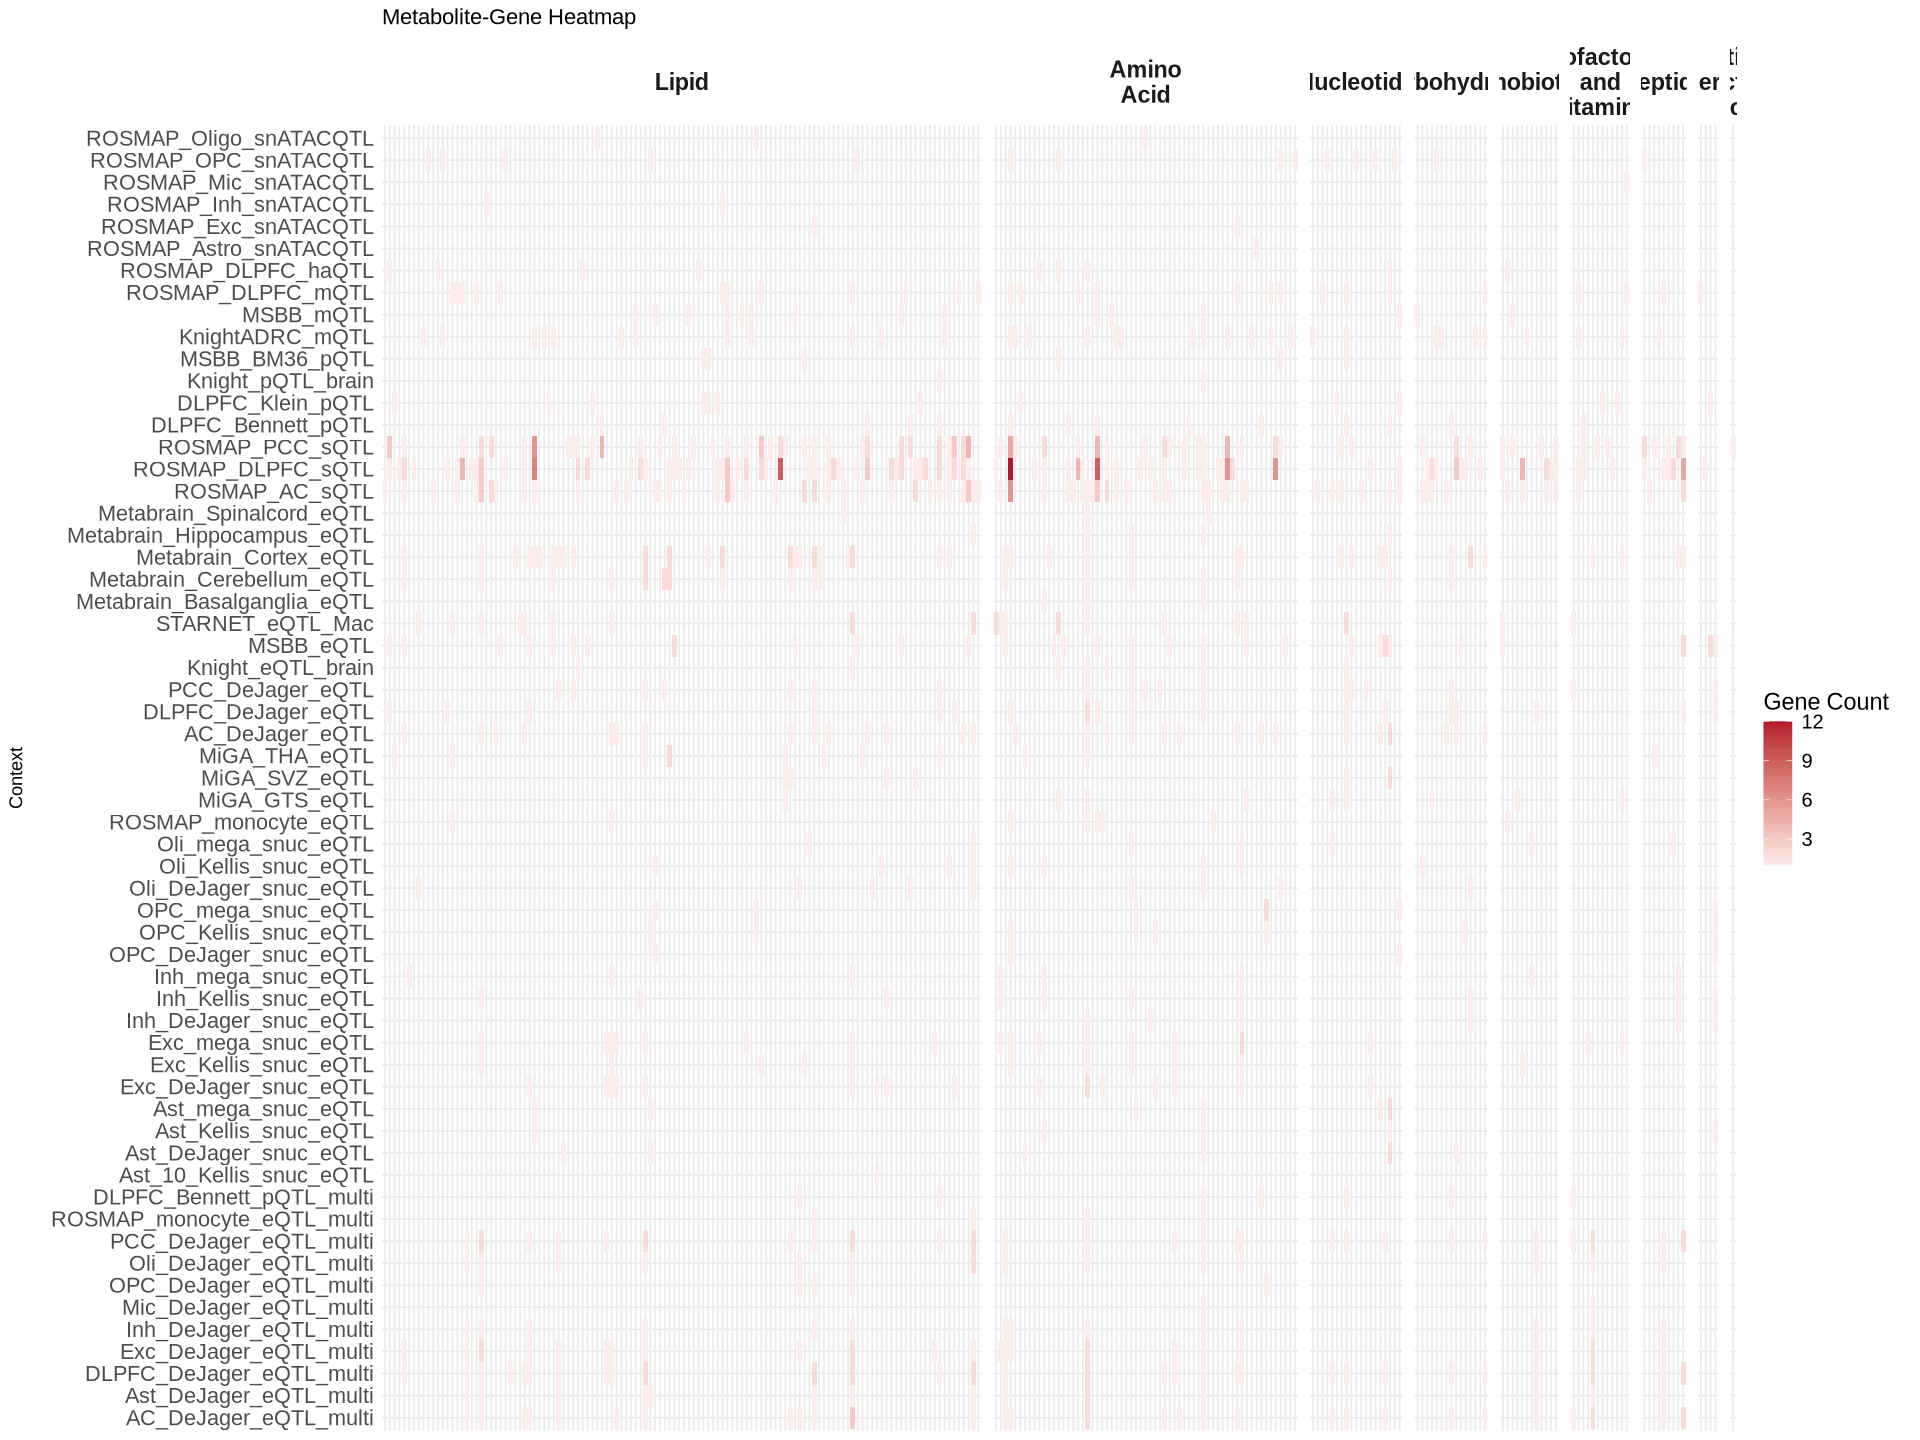

In [49]:
options(repr.plot.width = 16, repr.plot.height = 12)
p2 <- ggplot(df_merged, aes(x = metabolite, y = context_clean, fill = n_gene)) +
  geom_tile(color = NA) +  # Remove border lines
  scale_fill_gradient2(
    low = "#2166AC",  high = "#B2182B",
    name = "Gene Count"
  ) +
  facet_grid(~SUPER_PATHWAY, scales = "free_x", space = "free_x") +
  theme_minimal() +
  theme(
    axis.text.x = element_blank(),
    axis.ticks.x = element_blank(),
    axis.text.y = element_text(size = 13),
    strip.text = element_text(size = 14, face = "bold"),
    legend.title = element_text(size = 14),
    legend.text = element_text(size = 12),
    panel.spacing = unit(0.5, "lines"),
    axis.title.x = element_blank()
  ) +
  labs(
    y = "Context",
    title = "Metabolite-Gene Heatmap"
  )
p2

In [25]:
# Bin gene counts
df_merged <- df_merged %>% filter(n_gene > 0) %>% 
  mutate(
    gene_count_bin = case_when(
      n_gene == 1 ~ "1",
      n_gene == 2 ~ "2",
      n_gene == 3 ~ "3",
      n_gene == 4 ~ "4",
      n_gene >= 5 ~ ">5",
      TRUE ~ NA_character_
    ),
    gene_count_bin = factor(gene_count_bin, levels = c( "1", "2", "3", "4", ">5"))
  ) %>% distinct()
# Top annotation dataframe
top_annot <- df_merged %>%
  dplyr::select(metabolite, SUPER_PATHWAY) %>%
  distinct()

# Generate colors for SUPER_PATHWAY
super_colors <- setNames(RColorBrewer::brewer.pal(length(unique(df_merged$SUPER_PATHWAY)), "Set3"), unique(df_merged$SUPER_PATHWAY))


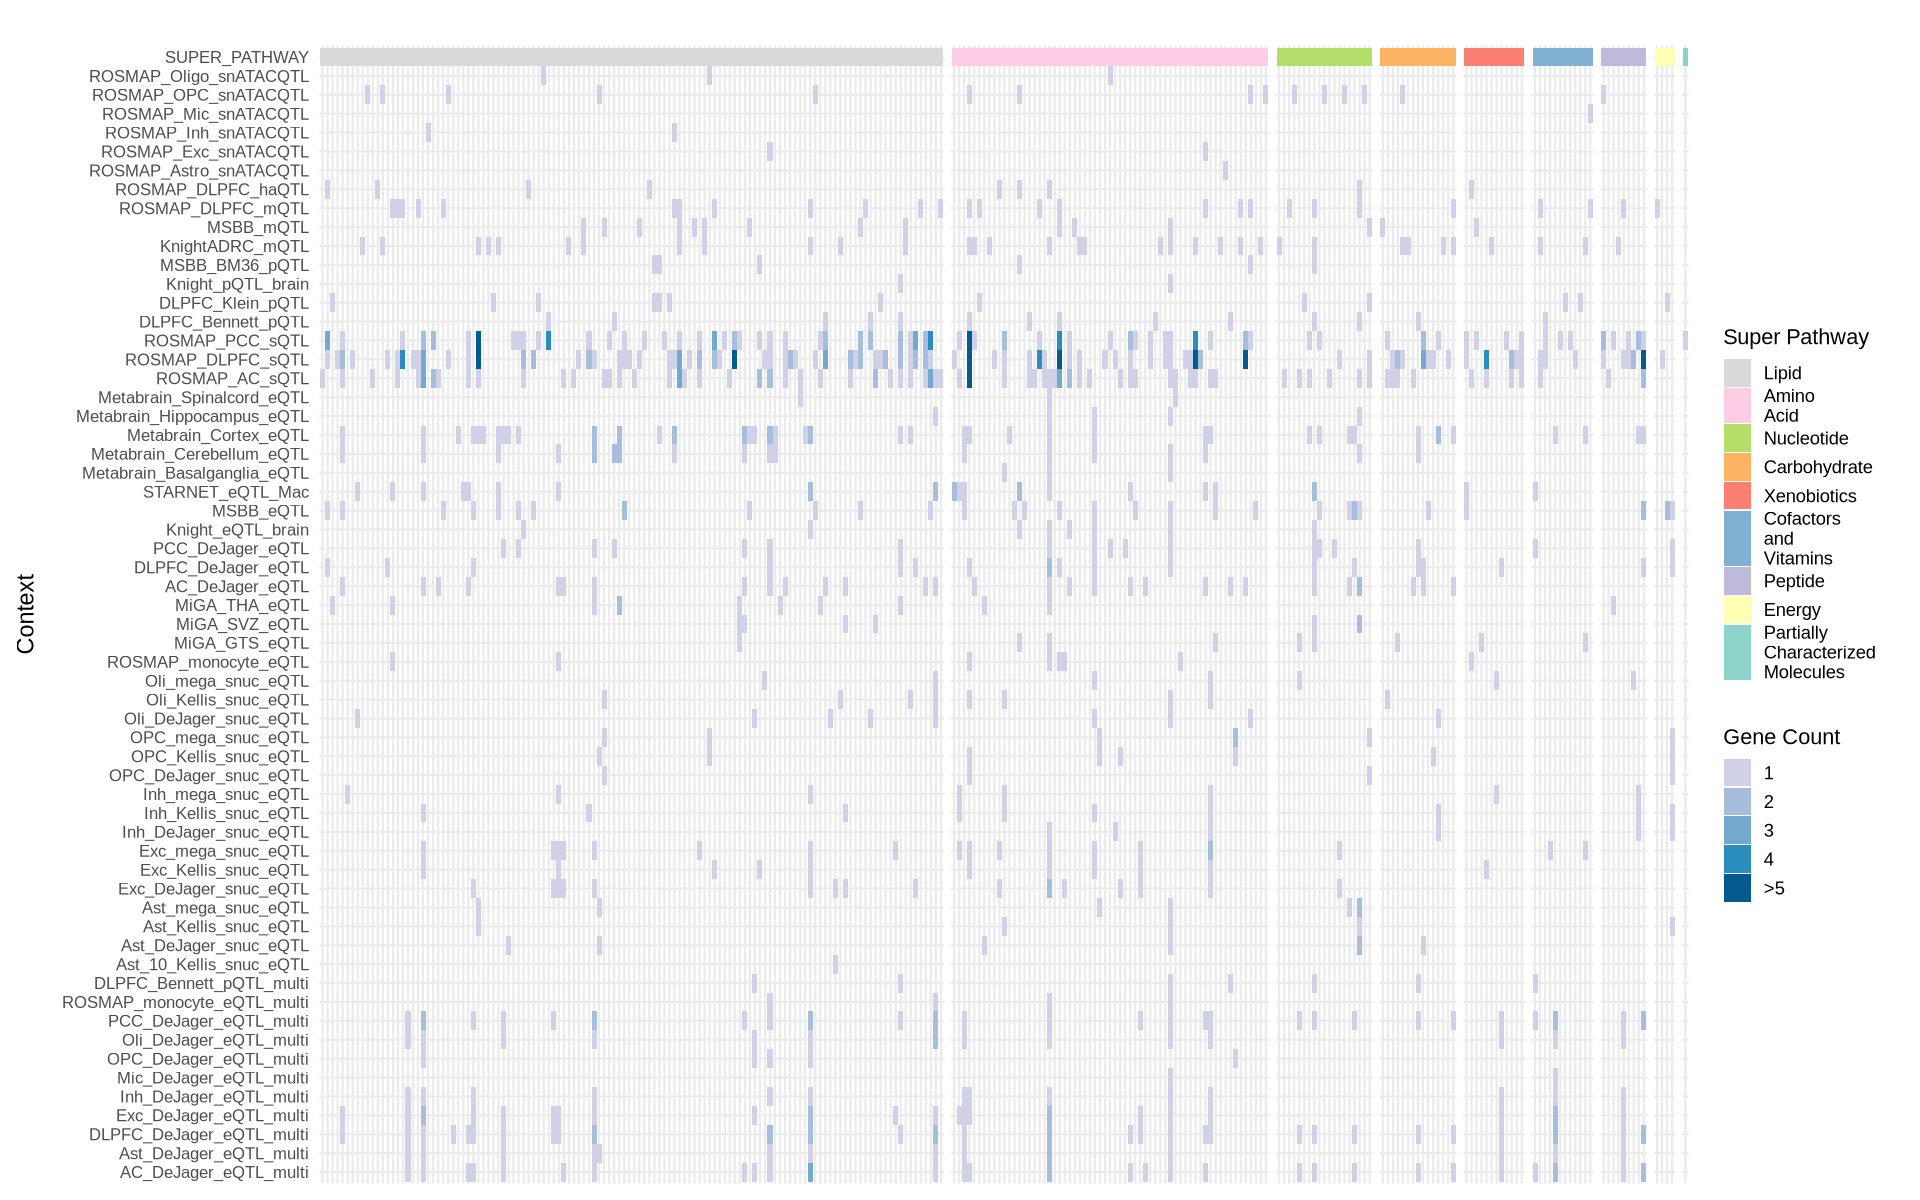

In [26]:
# Plot
p3 <- ggplot() +
  # Top bar: SUPER_PATHWAY
  geom_tile(data = top_annot, aes(x = metabolite, y = "SUPER_PATHWAY", fill = SUPER_PATHWAY), height = 1) +
  scale_fill_manual(values = super_colors, name = "Super Pathway") +

  ggnewscale::new_scale_fill() +  # allow new fill scale

  # Heatmap: gene count bins
  geom_tile(data = df_merged, aes(x = metabolite, y = context_clean, fill = gene_count_bin)) +
  scale_fill_manual(
    values = c("1" = "#d0d1e6", "2" = "#a6bddb", "3" = "#74a9cf", "4" = "#2b8cbe", ">5" = "#045a8d"),
    na.value = "grey90",
    name = "Gene Count"
  ) +

  facet_grid(~SUPER_PATHWAY, scales = "free_x", space = "free_x") +
  theme_minimal(base_size = 14) +
  theme(
    axis.text.x = element_blank(),
    axis.ticks.x = element_blank(),
    axis.text.y = element_text(size = 10),
    strip.text.x = element_text(angle = 45, hjust = 0, size = 0, face = "bold"),
    legend.title = element_text(size = 13),
    legend.text = element_text(size = 11),
    panel.spacing = unit(0.3, "lines"),
    plot.margin = margin(10, 10, 10, 10),
    axis.title.x = element_blank()
  ) +
  labs(
    y = "Context"
    #   ,
    # title = "Metabolite-Gene Heatmap with Super Pathway Annotation"
  )

p3

In [27]:
#ggsave('FunGen_xQTL_metabolites.coloc70.merged.Apr2025.flatten.pdf', height = 8, width=14)

In [28]:
res_df_sum %>% 
filter(str_detect(metabolite, 'CHEM100000282')) %>% #pull that metabolite
pull(contexts) %>% str_split(., '; ', simplify = T) %>% .[str_detect(., 'ROSMAP_DLPFC_sQTL')] %>% # pull sQTL contexts 
str_extract_all('ENSG[0-9]+') %>%  # pull related genes
unlist %>% unique %>% length

[1] 12

In [29]:
res_df_sum %>% 
filter(str_detect(metabolite, 'CHEM100001851')) %>% #pull that metabolite
pull(contexts) %>% str_split(., '; ', simplify = T) %>% .[str_detect(., 'ROSMAP_DLPFC_sQTL')] %>% # pull sQTL contexts 
str_extract_all('ENSG[0-9]+') %>%  # pull related genes
unlist %>% unique %>% length

[1] 9

In [30]:
res_df_sum %>% filter(str_detect(metabolite, 'CHEM100000282'))

metabolite                      n_gene
1 ROSMAP_metabolome_CHEM100000282 30    
  metabolite_regions                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                   
1 chr11_116513409_117835187_ROSMAP_metabolome_CHEM100000282; chr18_68166377_69581483_ROSMAP_metabolome_CHEM100000282; chr8_6537503_8880095_ROSMAP_metabolome_CHEM100000282; chr10_82231647_83966001_ROSMAP_metabolome_CHEM100000282; chr12_2067099_3219245_ROSMAP_metabolome_CHEM100000282; chr18_7090236_8658509_ROSMAP_metabolome_CHEM100000282; chr1_234364329_235656952_ROSMAP_metabolome_CHEM100000282; chr1_81525772_83003483_ROSMAP_metabolome_CHEM100000282; chr22_10516173_17414263_ROSMAP_metabolome_CHEM100000282; chr2_131938574_134400811_ROSMAP_metabolome_CHEM100000282; chr2_3926189_5567778_ROSMAP_metabolome_CHEM100000282; chr3_112690384_114706122_ROSMAP_metabolome_CHEM100000282; chr3_42375669_45108216_ROSMAP_metabolome_CHEM100000282; chr4_126353190_128547006_ROSMAP_metabolome_CHEM100000282; chr4_43205452_47542521_ROSMAP_metabolome_CHEM100000282; chr7_128149110_129951388_ROSMAP_metabolome_CHEM100000282; chr8_143034200_145075767_ROSMAP_metabolome_CHEM100000282; chr8_97568971_100485780_ROSMAP_metabolome_CHEM100000282; chr4_182023425_183841077_ROSMAP_metabolome_CHEM100000282
  contexts                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                      

In [41]:
#df_merged %>% filter(metabolite == 'CHEM100000282') %>% pull(contexts) %>% str_extract(., 'ENSG[0-9]+') %>% unique() %>% na.omit() %>% length # note: this code is not working

In [ ]:
#coloc_res_paths_df %>% filter(str_detect(metabolite_region, 'CHEM100000282'), str_detect(context_region, 'ROSMAP_DLPFC_sQTL')) %>% # pull metabolite and sQTL contexts 
#    pull(context_region) %>% str_extract_all('ENSG[0-9]+') %>%  # pull related genes
#    unlist %>% unique %>% length

In [ ]:
#coloc_res_paths_df %>% filter(str_detect(metabolite_region, 'CHEM100000282'), str_detect(context_region, 'ROSMAP_AC_sQTL')) %>% # pull metabolite and sQTL contexts 
#    pull(context_region) %>% str_extract_all('ENSG[0-9]+') %>%  # pull related genes
#    unlist %>% unique %>% length

In [31]:
metabolite_meta%>% filter(metabolite == 'CHEM100020421')

CHEM_ID,LIB_ID,COMP_ID,CHRO_LIB_ENTRY_ID,SUPER_PATHWAY,SUB_PATHWAY,PATHWAY_SORTORDER,PATHWAY_STATUS,TYPE,INCHIKEY,⋯,CHEMICAL_NAME,SHORT_NAME,CAS,CHEMSPIDER,HMDB,KEGG,PLANT_CYC,PUBCHEM,PLATFORM,metabolite
<int>,<int>,<int>,<int>,<chr>,<chr>,<int>,<lgl>,<chr>,<chr>,⋯,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>
100020421,209,62564,219915,Amino Acid,Tyrosine Metabolism,164,NA,NAMED,,⋯,1-carboxyethyltyrosine,1-carboxyethyltyrosine,,,,,,,LC/MS Neg,CHEM100020421


In [32]:
gene_ref <- fread('/data/resource/references/Homo_sapiens.GRCh38.103.chr.reformatted.collapse_only.gene.region_list') # path in cloud
#gene_ref <- fread('/restricted/projectnb/xqtl/jaempawi/xqtl/Staging/manuscript/xQTL_flagship_2025/PPI/Homo_sapiens.GRCh38.103.chr.reformatted.collapse_only.gene.region_list') # path in BU cluster
gene_ref %>% head

#chr,start,end,gene_id,gene_name
<chr>,<int>,<int>,<chr>,<chr>
chr1,11868,11869,ENSG00000223972,DDX11L1
chr1,17435,17436,ENSG00000278267,MIR6859-1
chr1,29553,29554,ENSG00000243485,MIR1302-2HG
chr1,29569,29570,ENSG00000227232,WASH7P
chr1,30365,30366,ENSG00000284332,MIR1302-2
chr1,36080,36081,ENSG00000237613,FAM138A


In [33]:
res_df_sum_long %>% filter(str_detect(contexts, "Mic")) %>% mutate(gene_id = str_extract(contexts, 'ENSG[0-9]+')) %>% merge(gene_ref) %>% dplyr::select(-metabolite_regions, -contexts) %>% merge(metabolite_meta %>% dplyr::select(metabolite,SUPER_PATHWAY,  SUB_PATHWAY))

metabolite,gene_id,n_gene,context_clean,#chr,start,end,gene_name,SUPER_PATHWAY,SUB_PATHWAY
<chr>,<chr>,<int>,<chr>,<chr>,<int>,<int>,<chr>,<chr>,<chr>
CHEM100001468,ENSG00000145390,2,Mic_DeJager_eQTL_multi,chr4,119212635,119212636,USP53,Cofactors and Vitamins,Nicotinate and Nicotinamide Metabolism
CHEM100020421,ENSG00000133313,1,Mic_DeJager_eQTL_multi,chr18,74495815,74495816,CNDP2,Amino Acid,Tyrosine Metabolism


In [34]:
res_df_sum_long %>% filter(str_detect(contexts, "Ast")) %>% mutate(gene_id = str_extract(contexts, 'ENSG[0-9]+')) %>% merge(gene_ref) %>% dplyr::select(-metabolite_regions, -contexts) %>% merge(metabolite_meta %>% dplyr::select(metabolite,SUPER_PATHWAY,  SUB_PATHWAY)) %>% distinct

metabolite,gene_id,n_gene,context_clean,#chr,start,end,gene_name,SUPER_PATHWAY,SUB_PATHWAY
<chr>,<chr>,<int>,<chr>,<chr>,<int>,<int>,<chr>,<chr>,<chr>
CHEM100000272,ENSG00000165055,1,Ast_DeJager_eQTL_multi,chr7,128476747,128476748,METTL2B,Amino Acid,"Glycine, Serine and Threonine Metabolism"
CHEM100000787,ENSG00000151067,2,Ast_DeJager_snuc_eQTL,chr12,1970785,1970786,CACNA1C,Amino Acid,Alanine and Aspartate Metabolism
CHEM100001247,ENSG00000099219,1,Ast_DeJager_eQTL_multi,chr9,5833116,5833117,ERMP1,Lipid,"Fatty Acid Metabolism (Acyl Carnitine, Medium Chain)"
CHEM100001253,ENSG00000203546,3,Ast_Kellis_snuc_eQTL,chr14,31457440,31457441,AL139353.1,Amino Acid,Glutamate Metabolism
CHEM100001468,ENSG00000145390,2,Ast_DeJager_eQTL_multi,chr4,119212635,119212636,USP53,Cofactors and Vitamins,Nicotinate and Nicotinamide Metabolism
CHEM100001481,ENSG00000152102,3,Ast_DeJager_eQTL_multi,chr2,131093459,131093460,FAM168B,Lipid,Monoacylglycerol
CHEM100001662,ENSG00000160213,15,Ast_mega_snuc_eQTL,chr21,43776329,43776330,CSTB,Lipid,Carnitine Metabolism
CHEM100001662,ENSG00000104714,15,Ast_Kellis_snuc_eQTL,chr8,738105,738106,ERICH1,Lipid,Carnitine Metabolism
CHEM100001668,ENSG00000147813,4,Ast_DeJager_eQTL_multi,chr8,143578342,143578343,NAPRT,Amino Acid,Histidine Metabolism


In [35]:
target_id = 'ENSG00000137269'

In [36]:
res_df_sum_long %>% filter(str_detect(contexts, "Ast")) %>% mutate(gene_id = str_extract(contexts, 'ENSG[0-9]+')) %>% merge(gene_ref) %>% merge(metabolite_meta %>% dplyr::select(metabolite,SUPER_PATHWAY,  SUB_PATHWAY)) %>% distinct %>% filter(gene_id ==target_id)

metabolite,gene_id,n_gene,metabolite_regions,contexts,context_clean,#chr,start,end,gene_name,SUPER_PATHWAY,SUB_PATHWAY
<chr>,<chr>,<int>,<chr>,<chr>,<chr>,<chr>,<int>,<int>,<chr>,<chr>,<chr>
CHEM872,ENSG00000137269,5,chr19_56918544_58607520_ROSMAP_metabolome_CHEM872; chr6_52730905_54027603_ROSMAP_metabolome_CHEM872,ROSMAP_Kellis_eQTL.ENSG00000137269.univariate_bvsr_Ast_Kellis_eQTL_ENSG00000137269,Ast_Kellis_snuc_eQTL,chr6,53794496,53794497,LRRC1,Nucleotide,"Pyrimidine Metabolism, Thymine containing"
CHEM872,ENSG00000137269,5,chr19_56918544_58607520_ROSMAP_metabolome_CHEM872; chr6_52730905_54027603_ROSMAP_metabolome_CHEM872,ROSMAP_mega_eQTL.ENSG00000137269.univariate_bvsr_Ast_mega_eQTL_ENSG00000137269,Ast_mega_snuc_eQTL,chr6,53794496,53794497,LRRC1,Nucleotide,"Pyrimidine Metabolism, Thymine containing"
CHEM872,ENSG00000137269,5,chr19_56918544_58607520_ROSMAP_metabolome_CHEM872; chr6_52730905_54027603_ROSMAP_metabolome_CHEM872,ROSMAP_DeJager_eQTL.ENSG00000137269.univariate_bvsr_Ast_DeJager_eQTL_ENSG00000137269,Ast_DeJager_snuc_eQTL,chr6,53794496,53794497,LRRC1,Nucleotide,"Pyrimidine Metabolism, Thymine containing"


In [37]:
res <- readRDS('FunGen_xQTL_metabolites.coloc70.merged.Apr2025.rds')
matched_files <- lapply(res, function(x) {
  if (any(grepl(target_id, x$coloc_files))) {
    return(x$coloc_files[grepl(target_id, x$coloc_files) & grepl('Ast', x$coloc_files)])
  } else {
    return(NULL)
  }
})
matched_files <- unlist(matched_files[!sapply(matched_files, is.null)])
#matched_files <- matched_files %>% gsub('/data/analysis_result/coloc/','/home/ubuntu/data/restored_dir',.)  # some files in in glacier storage

In [ ]:
#matched_files

In [ ]:
#res1 <- readRDS(matched_files[1])
#res1_cs <- res1[[1]]$sets$cs %>% unlist
#res2 <- readRDS(matched_files[2])
#res2_cs <- res2[[1]]$sets$cs %>% unlist
#res3 <- readRDS(matched_files[3])
#res3_cs <- res3[[1]]$sets$cs %>% unlist

In [ ]:
#res1[[1]]$sets

In [ ]:
#Reduce(intersect, list(res1_cs, res2_cs, res3_cs)) %>% str_split(., ":", simplify = T) %>% .[,2] %>% as.numeric %>% summary